In [7]:
!pip install jax numpyro pydantic statsmodels

  Using cached statsmodels-0.14.4-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.2 kB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
Using cached statsmodels-0.14.4-cp312-cp312-macosx_11_0_arm64.whl (9.9 MB)
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [8]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
from jax import random
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS, Predictive
from pydantic import BaseModel, Field
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [9]:
class DataGeneratingProcessParams(BaseModel):
    """Parameters for the data generating process."""

    n: int = Field(..., description="Number of samples")
    ar_1_demand: float = Field(..., description="AR(1) coefficient for the demand")
    ar_2_demand: float = Field(..., description="AR(2) coefficient for the demand")
    seasonal_frequency_demand: int = Field(
        ..., description="Seasonal frequency for the demand", gt=0
    )
    seasonal_amplitude_demand: float = Field(
        ..., description="Amplitude of the seasonality"
    )
    constant_term_demand: float = Field(..., description="Constant term for the demand")
    demand_sales_delta: float = Field(
        ..., description="Delta between demand and sales", gt=0
    )
    sigma_noise_demand: float = Field(
        ..., description="Standard deviation of the noise for the demand", gt=0
    )
    sigma_noise_sales: float = Field(
        ..., description="Standard deviation of the noise for the sales", gt=0
    )
    is_available_rate: float = Field(
        ..., description="Rate of availability of the product", ge=0, le=1
    )
    max_caparity: float = Field(
        ...,
        description="Maximum capacity of the product (max possible sales per period)",
        gt=0,
    )


data_params = DataGeneratingProcessParams(
    n=180,
    ar_1_demand=0.6,
    ar_2_demand=0.3,
    seasonal_frequency_demand=7,
    seasonal_amplitude_demand=0.6,
    constant_term_demand=0.2,
    demand_sales_delta=0.25,
    sigma_noise_demand=0.3,
    sigma_noise_sales=0.5,
    is_available_rate=0.80,
    max_caparity=2.2,
)

In [10]:
def demand_sales_dgp(rng_key, params):
    """Simulate the demand and sales for a product.

    We model the demand as an AR(2) process with a seasonal component. The sales are
    generated by adding noise to the demand and subtracting the delta between demand
    and sales. The sales are also subject to availability capacity constraints.

    Parameters
    ----------
    rng_key : jax.random.PRNGKey
        Random key for reproducibility
    params : DataGeneratingProcessParams
        Parameters for the data generating process.

    Returns
    -------
    Tuple
        Tuple with the time, demand, sales, sales observed, and availability data.
    """
    t = jnp.arange(start=0, stop=params.n, step=1)
    demand = 2 * jnp.ones_like(t, dtype=jnp.float32)
    sales = jnp.zeros_like(t, dtype=jnp.float32)
    sales_obs = jnp.zeros_like(t, dtype=jnp.float32)

    rng_key, rng_subkey = random.split(rng_key)
    noise_demand = params.sigma_noise_demand * random.normal(
        rng_subkey, shape=(t.size,)
    )

    rng_key, rng_subkey = random.split(rng_key)
    noise_sales = params.sigma_noise_sales * random.normal(rng_subkey, shape=(t.size,))

    rng_key, rng_subkey = random.split(rng_key)
    is_available = random.bernoulli(
        rng_subkey, params.is_available_rate, shape=(t.size,)
    ).astype(jnp.float32)

    for i in range(2, t.size):
        demand_i = (
            params.ar_1_demand * demand[i - 1]
            + params.ar_2_demand * demand[i - 2]
            + params.seasonal_amplitude_demand * jnp.sin(2 * jnp.pi * t[i] / 7)
            + params.constant_term_demand
            + noise_demand[i]
        )
        demand_i = jnp.maximum(demand_i, 0)
        demand = demand.at[i].set(demand_i)

        sales_i = demand[i] + noise_sales[i] - params.demand_sales_delta
        sales_i = jnp.minimum(sales_i, demand_i)
        sales_i = jnp.maximum(sales_i, 0)
        sales_i_obs = is_available[i] * sales_i
        sales_i_obs = jnp.minimum(sales_i_obs, params.max_caparity)
        sales = sales.at[i].set(sales_i) 
        sales_obs = sales_obs.at[i].set(sales_i_obs) 

    return t, demand, sales, sales_obs, is_available


rng_key, rng_subkey = random.split(rng_key)
t, demand, sales, sales_obs, is_available = demand_sales_dgp(rng_subkey, data_params)

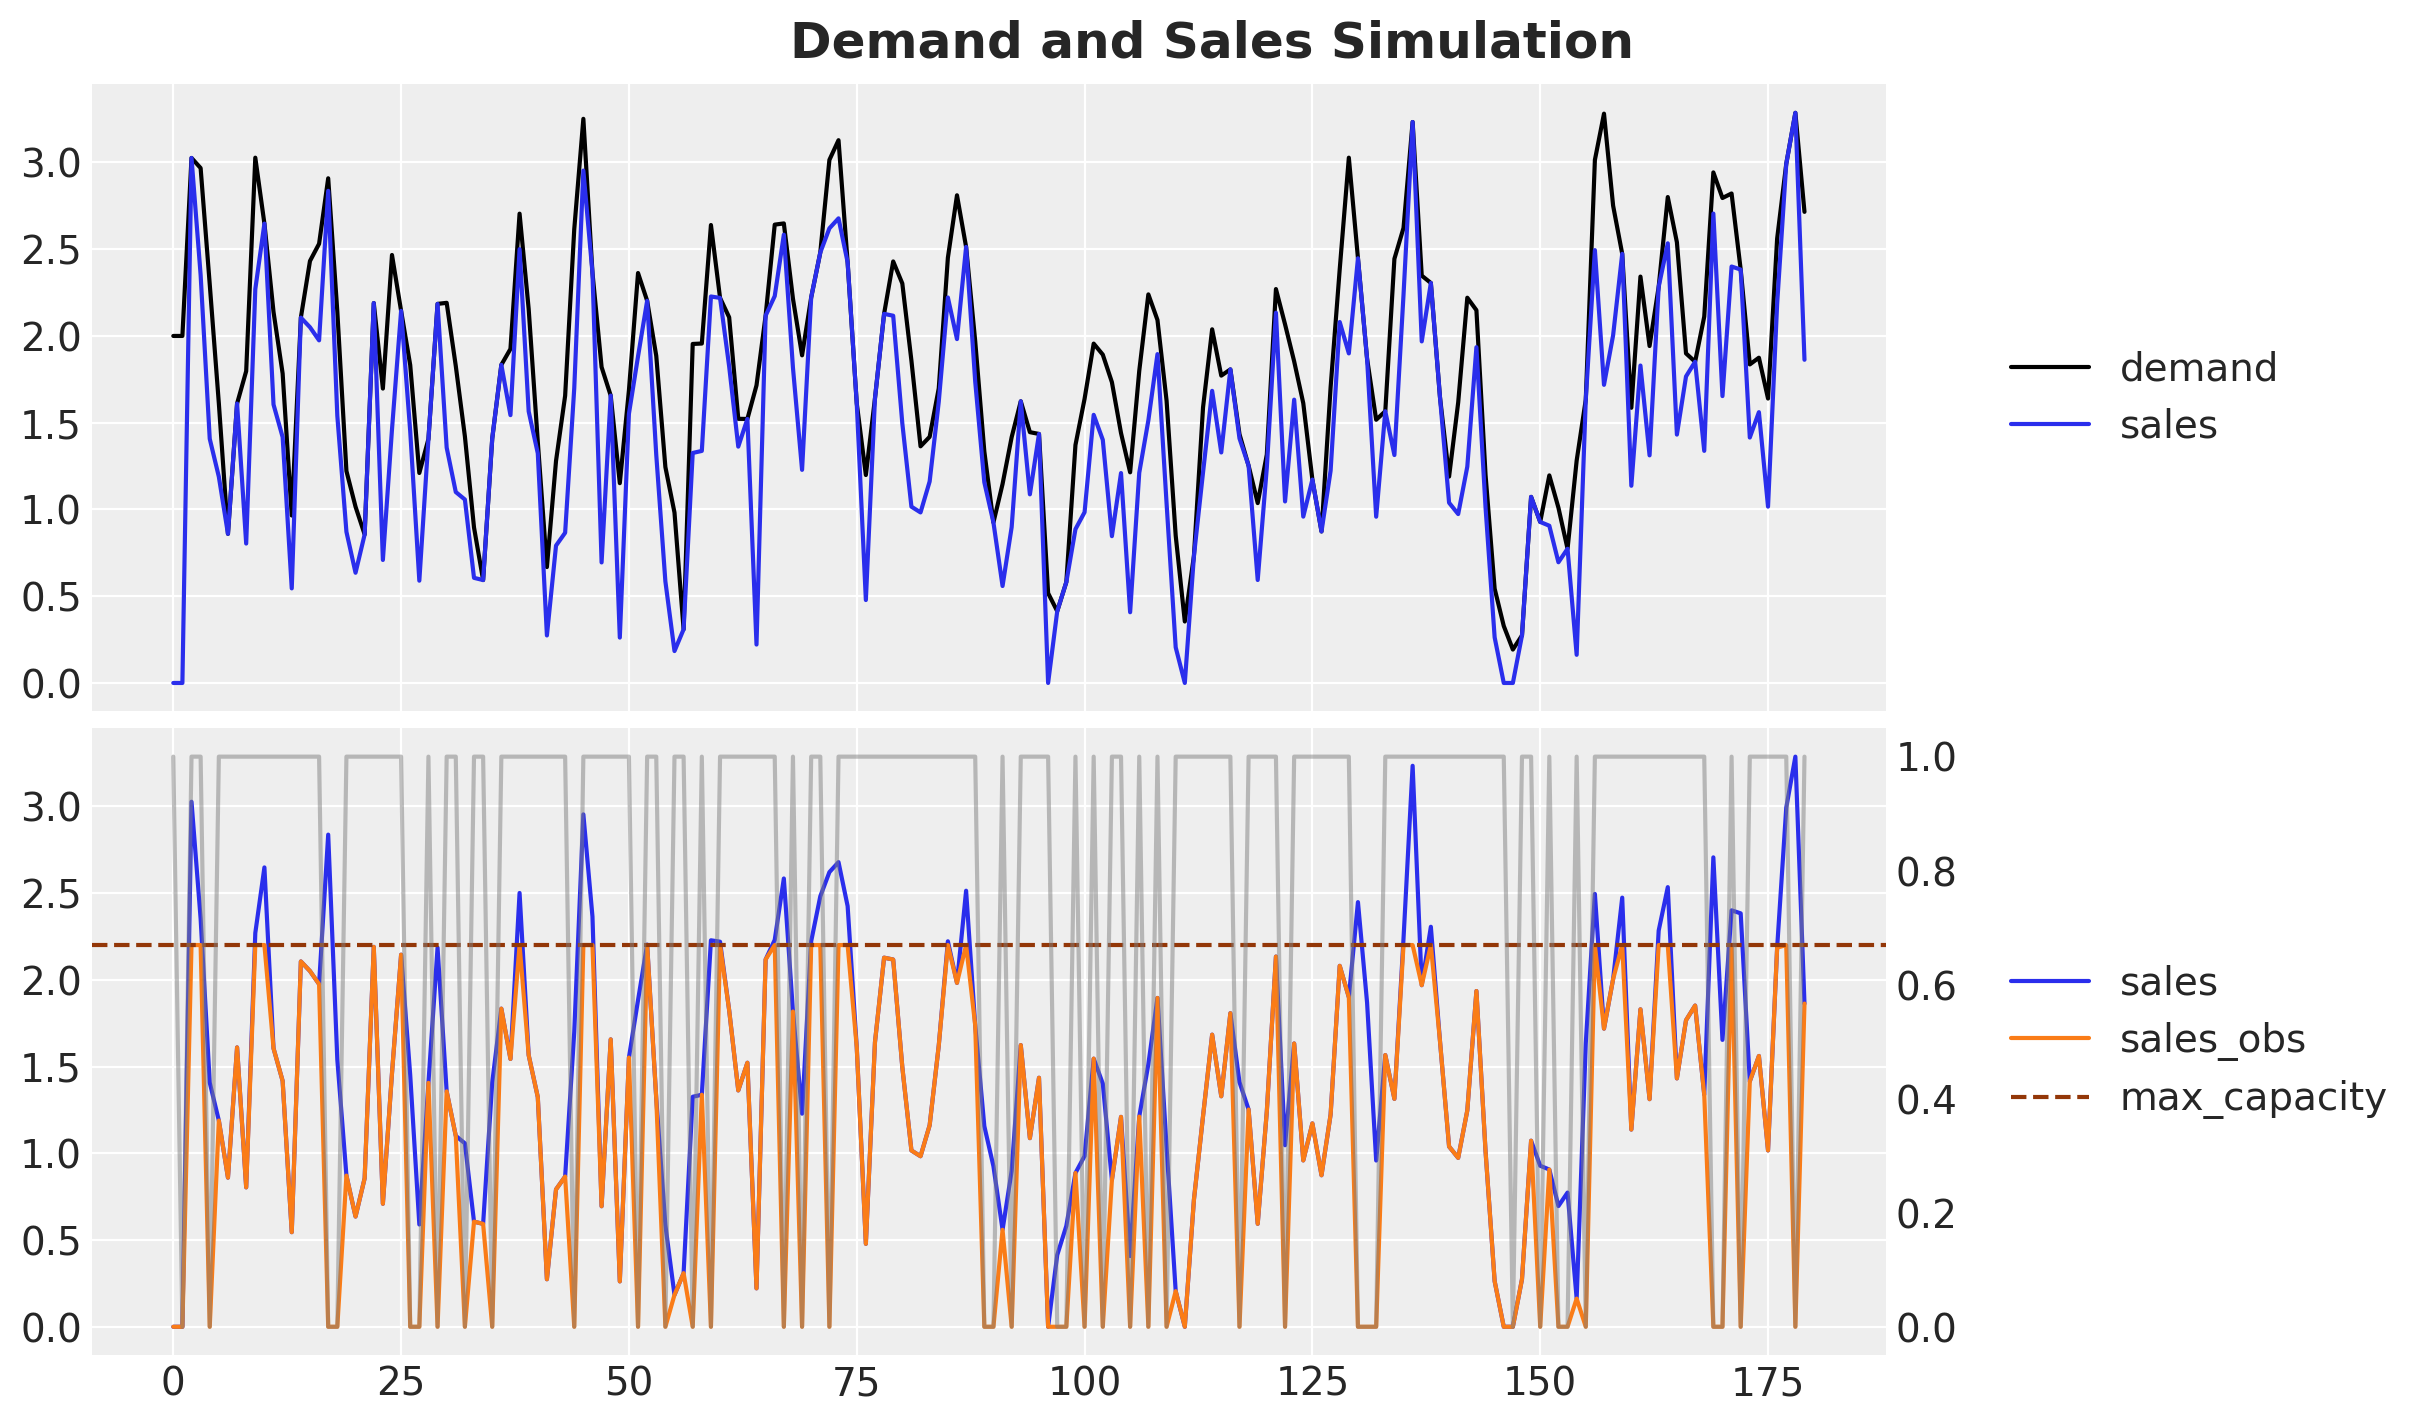

In [11]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 7),
    sharex=True,
    sharey=True,
    layout="constrained",
)

ax[0].plot(t, demand, c="black", label="demand")
ax[0].plot(t, sales, c="C0", label="sales")
ax[0].legend(loc="center left", bbox_to_anchor=(1.05, 0.5))

ax[1].plot(t, sales, c="C0", label="sales")
ax[1].plot(t, sales_obs, c="C1", label="sales_obs")
ax1_twin = ax[1].twinx()
ax1_twin.plot(t, is_available, c="gray", alpha=0.5, label="is_available")
ax[1].axhline(
    data_params.max_caparity, color="C4", linestyle="--", label="max_capacity"
)
ax1_twin.grid(None)
ax[1].legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
fig.suptitle("Demand and Sales Simulation", fontsize=18, fontweight="bold");

In [12]:
forecast_horizon = 30

t_train = t[:-forecast_horizon]
demand_train = demand[:-forecast_horizon]
sales_train = sales[:-forecast_horizon]
sales_obs_train = sales_obs[:-forecast_horizon]
is_available_train = is_available[:-forecast_horizon]
max_capacity_train = (sales_obs_train == data_params.max_caparity).astype(int)

t_test = t[-forecast_horizon:]
demand_test = demand[-forecast_horizon:]
sales_test = sales[-forecast_horizon:]
sales_obs_test = sales_obs[-forecast_horizon:]
is_available_test = is_available[-forecast_horizon:]
is_available_test_expected = jnp.ones_like(is_available_test)
max_capacity_test_expected = jnp.zeros_like(sales_obs_test)

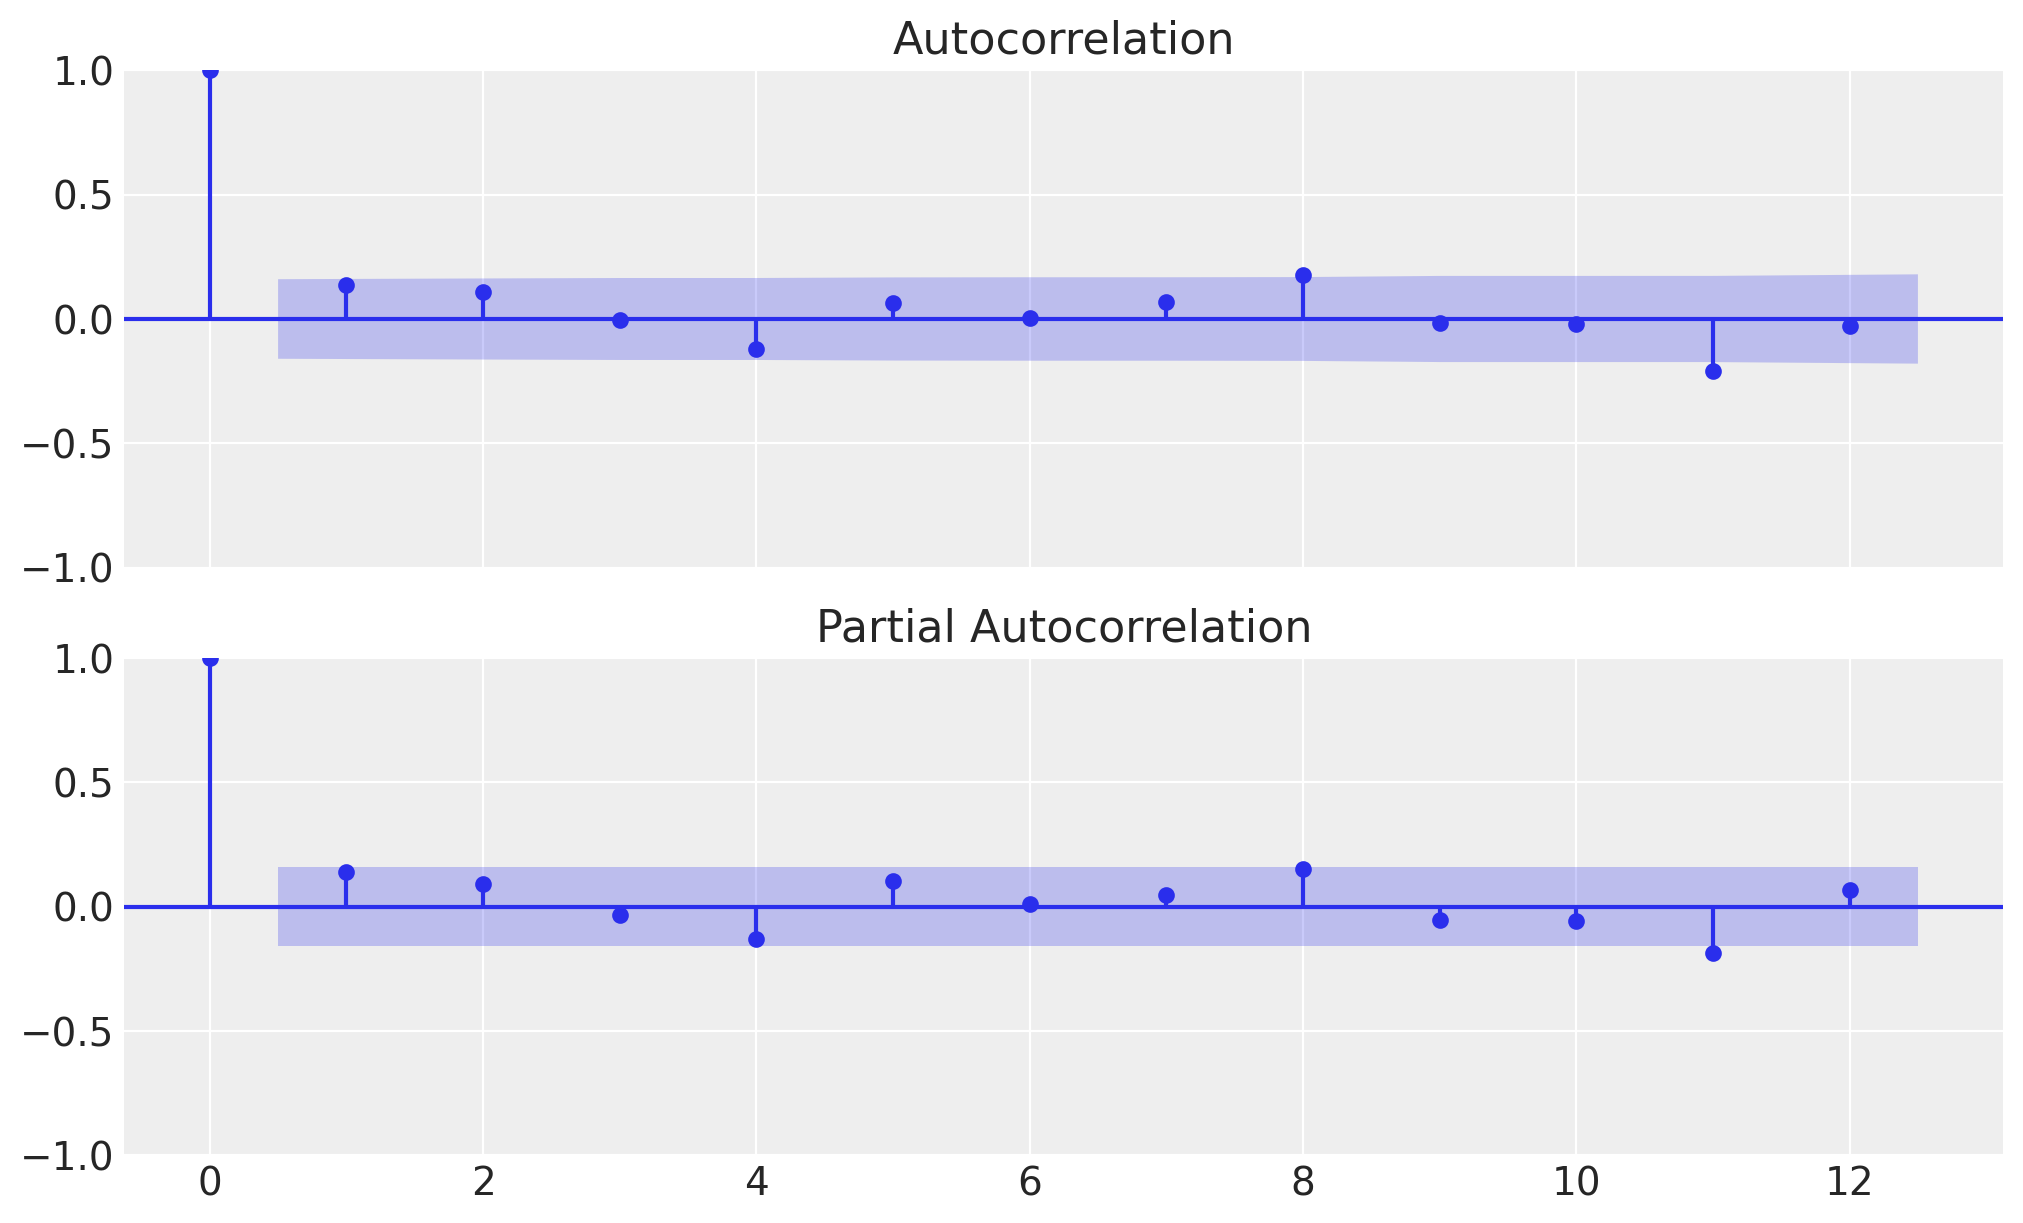

In [13]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10, 6), layout="constrained"
)

_ = plot_acf(sales_obs_train, lags=12, ax=ax[0])
_ = plot_pacf(sales_obs_train, lags=12, ax=ax[1])

In [14]:
# order of the Fourier features
n_order = 2  # this implies we will have 4 features (sin and cos for order 1 and 2)

fourier_features_df = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * t * order / 7)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

fourier_features_train_df = fourier_features_df.iloc[: len(t_train)]
fourier_features_test_df = fourier_features_df.iloc[len(t_train) :]

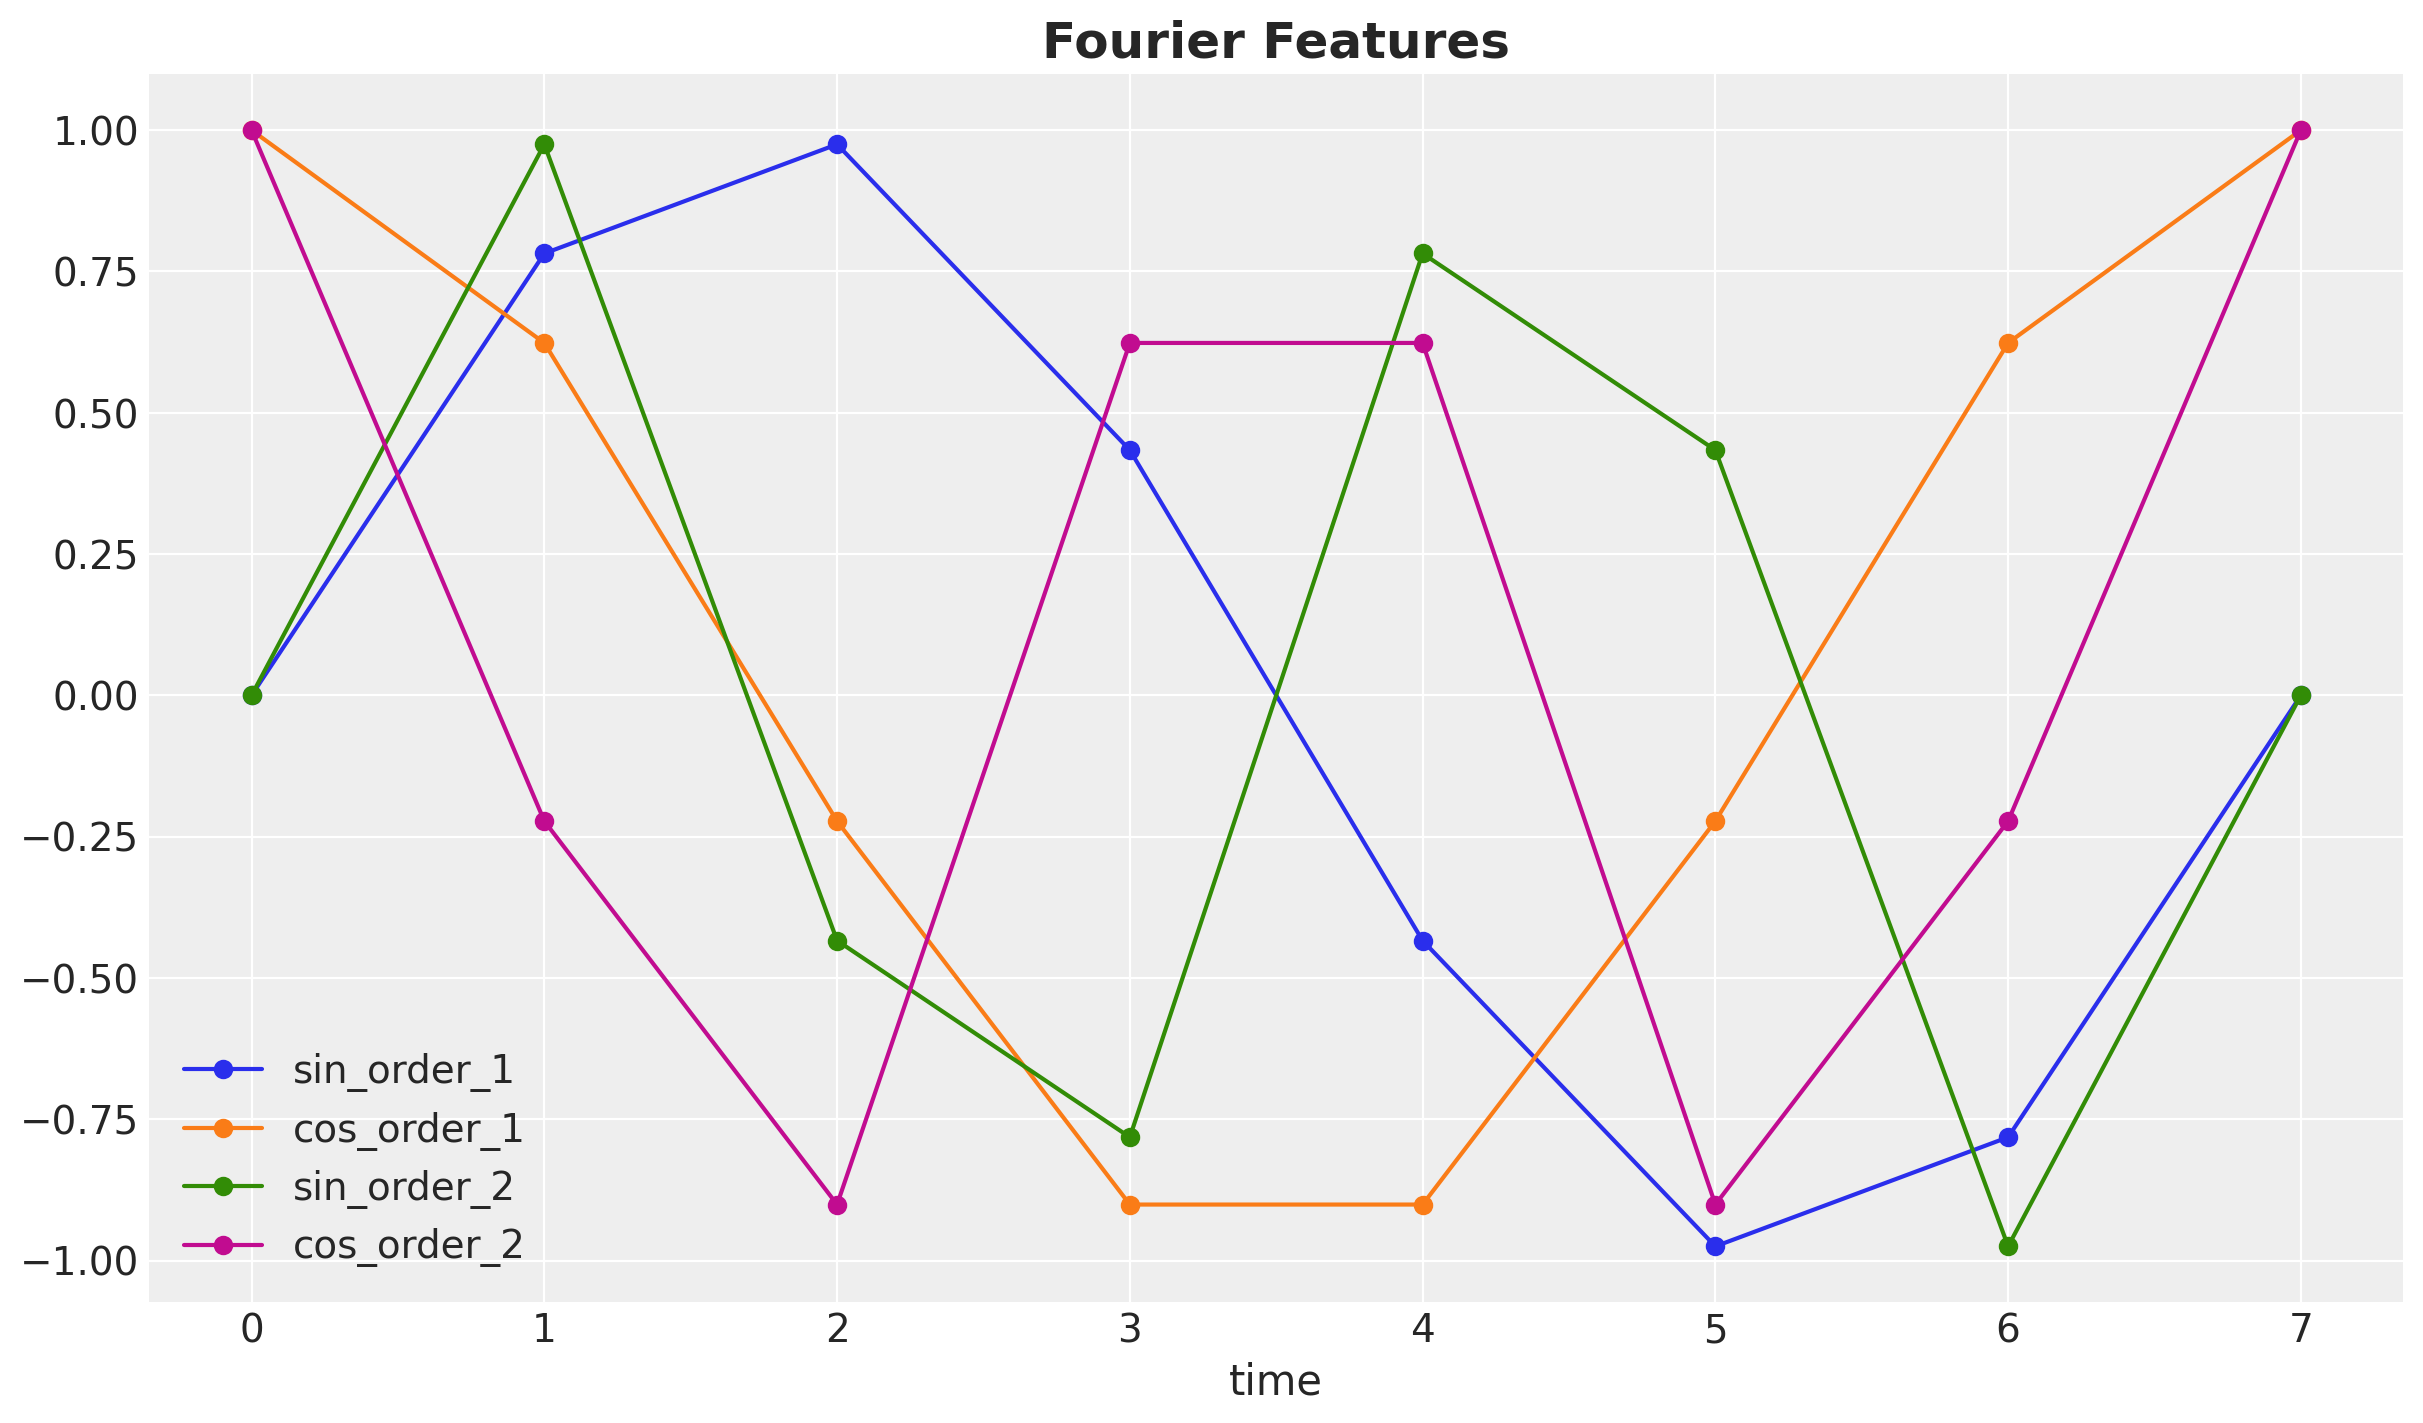

In [15]:
fig, ax = plt.subplots()
fourier_features_df.head(8).plot(marker="o", ax=ax)
ax.set(xlabel="time", ylabel=None)
ax.set_title("Fourier Features", fontsize=18, fontweight="bold");

In [16]:
fourier_features = jnp.array(fourier_features_df.to_numpy(), dtype=jnp.float32)

fourier_features_train = fourier_features[:-forecast_horizon]
fourier_features_test = fourier_features[-forecast_horizon:]

In [17]:
x_train_df = fourier_features_train_df
x_train_df = x_train_df.assign(is_available=is_available_train)

x_test_df = fourier_features_test_df
x_test_df = x_test_df.assign(is_available=is_available_test_expected)

In [18]:
model = ARIMA(
    endog=np.asarray(sales_obs_train),
    exog=x_train_df,
    order=(2, 0, 0),
)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  150
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -103.391
Date:                Mon, 02 Dec 2024   AIC                            224.781
Time:                        12:25:50   BIC                            251.877
Sample:                             0   HQIC                           235.789
                                - 150                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0196      0.135      0.145      0.884      -0.245       0.285
sin_order_1      0.2690      0.061      4.439      0.000       0.150       0.388
cos_order_1     -0.3075      0.064     -4.791      0.000      -0.433      -0.182
sin_order_2      0.0054      0.053      0.101      0.920      -0.099       0.110
cos_order_2      0.0673      0.050      1.344      0.179      -0.031       0.165
is_available     1.3429      0.133     10.130      0.000       1.083       1.603
ar.L1            0.1748      0.083      2.102      0.036       0.012       0.338
ar.L2            0.0931      0.085      1.098      0.272      -0.073       0.259
sigma2           0.2323      0.033      6.953      0.000       0.167       0.298
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.38
Prob(Q):                              0.91   Prob(JB):                         0.18
Heteroskedasticity (H):               0.75   Skew:                            -0.26
Prob(H) (two-sided):                  0.32   Kurtosis:                         2.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

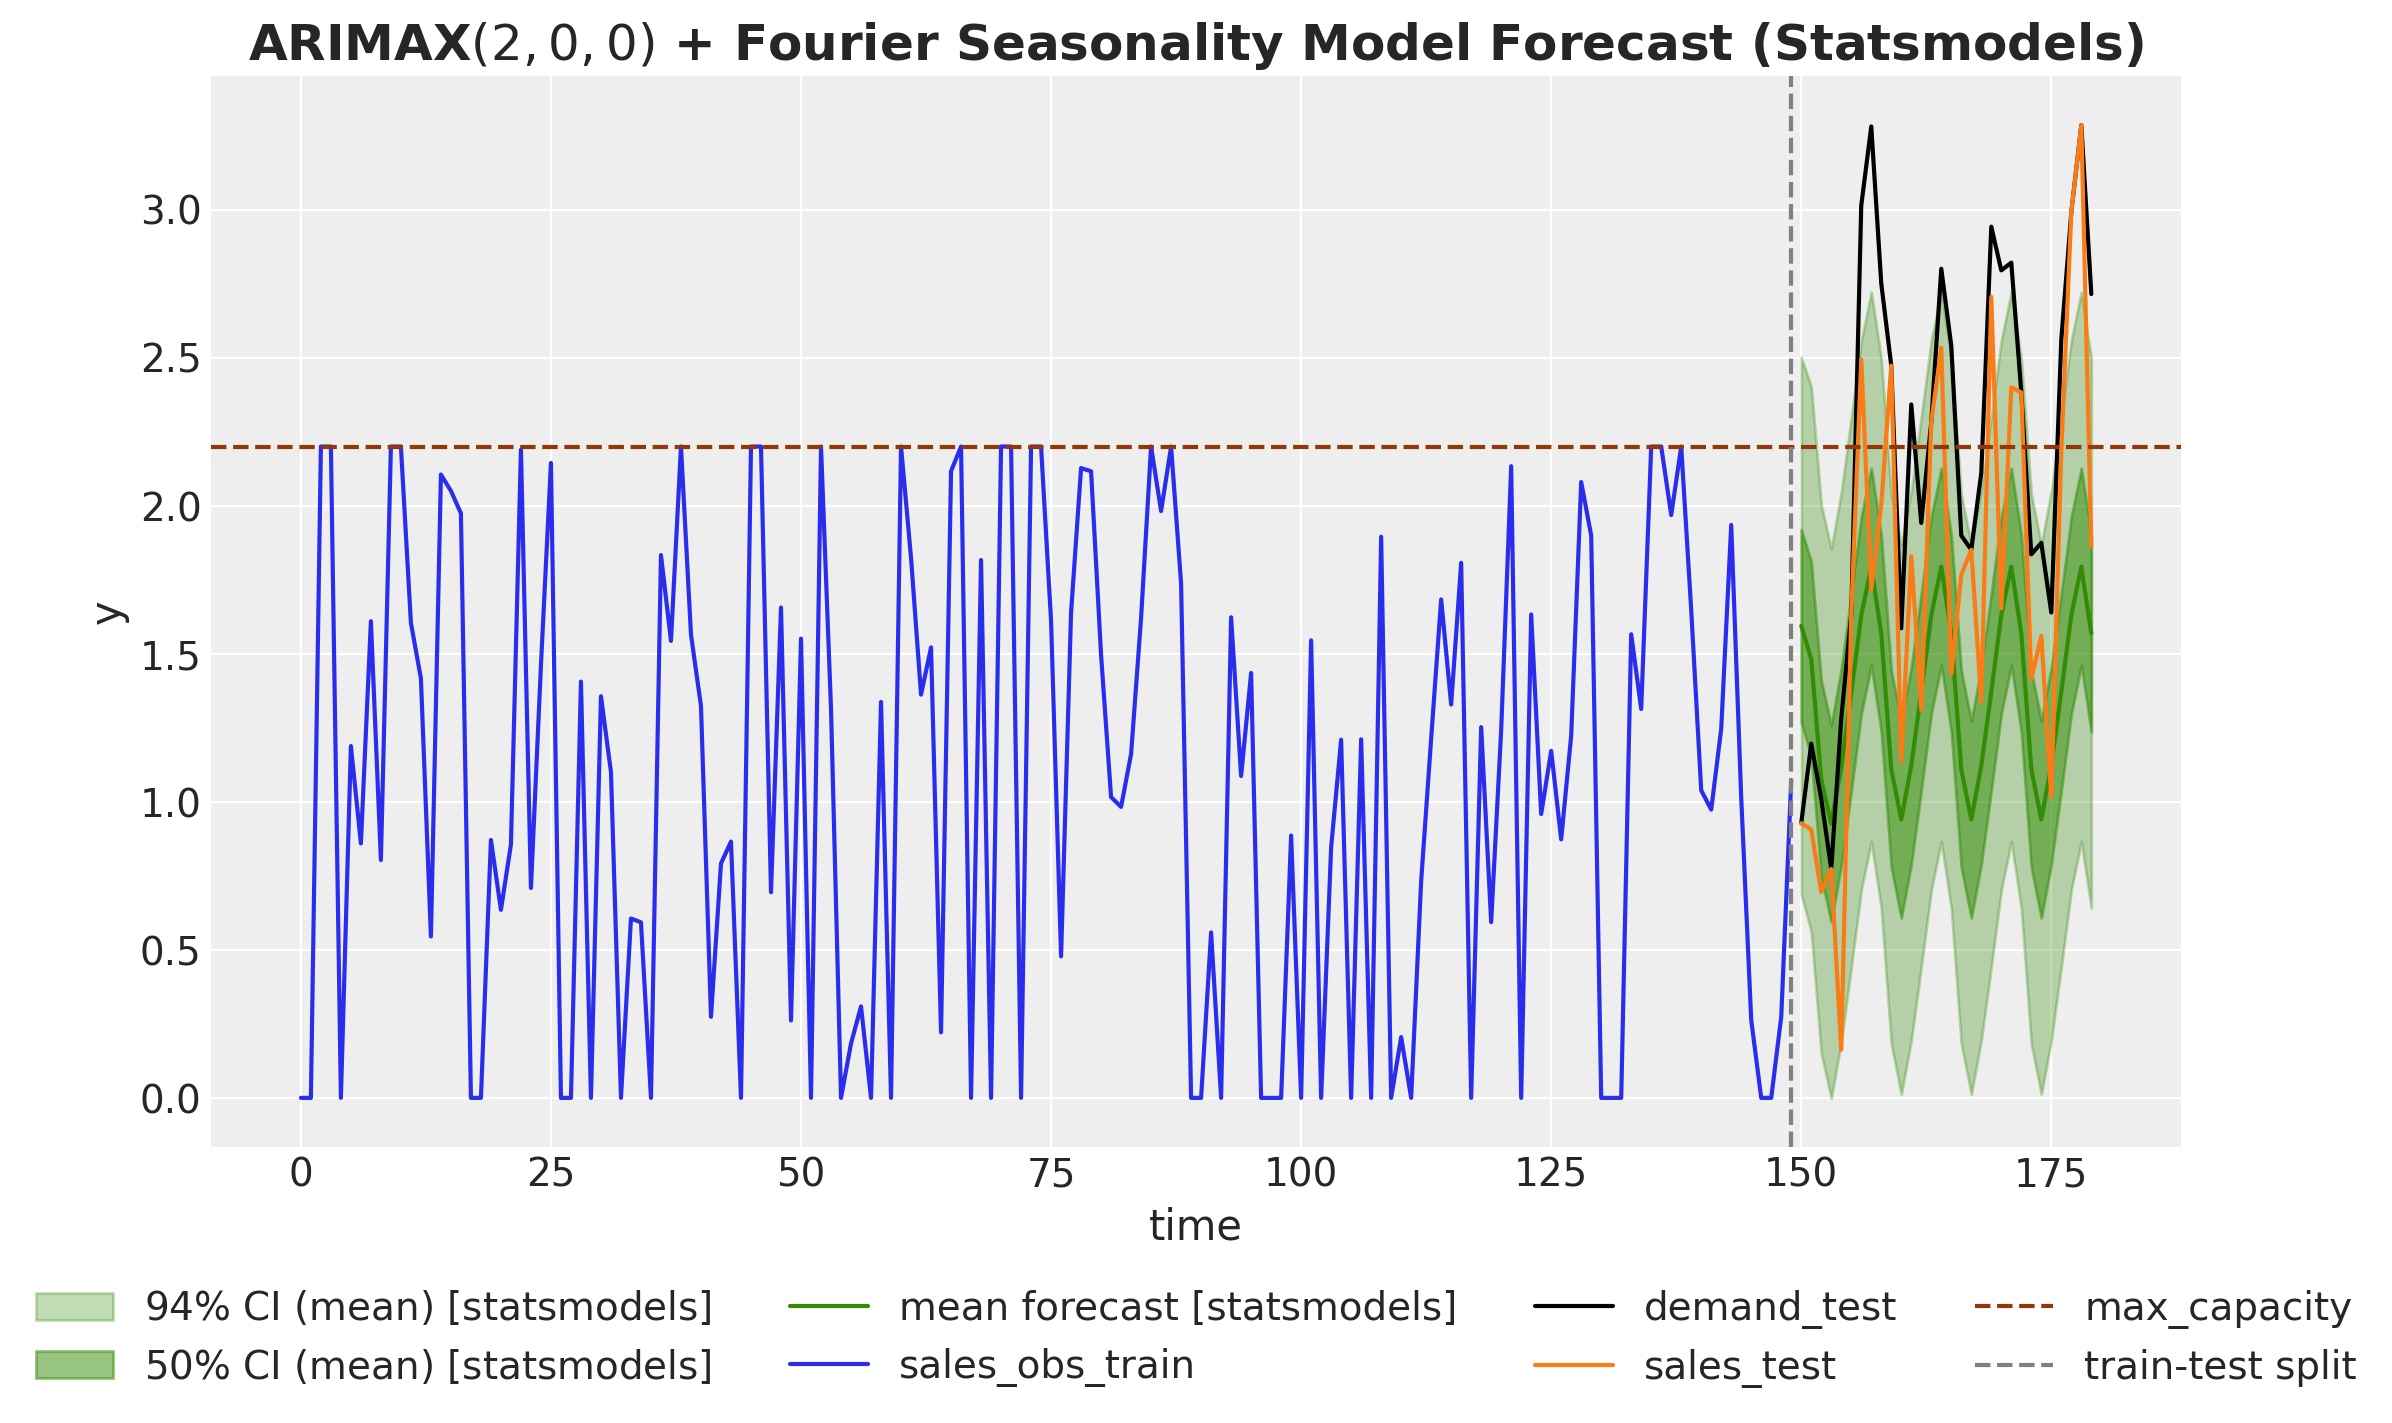

In [19]:
forecast_94_df = result.get_forecast(
    steps=sales_obs_test.size, exog=x_test_df
).summary_frame(alpha=0.06)

forecast_50_df = result.get_forecast(
    steps=sales_obs_test.size, exog=x_test_df
).summary_frame(alpha=0.5)

fig, ax = plt.subplots()
ax.fill_between(
    t_test,
    forecast_94_df["mean_ci_lower"],
    forecast_94_df["mean_ci_upper"],
    color="C2",
    alpha=0.3,
    label=r"$94\%$ CI (mean) [statsmodels]",
)
ax.fill_between(
    t_test,
    forecast_50_df["mean_ci_lower"],
    forecast_50_df["mean_ci_upper"],
    color="C2",
    alpha=0.5,
    label=r"$50\%$ CI (mean) [statsmodels]",
)
ax.plot(t_test, forecast_94_df["mean"], color="C2", label="mean forecast [statsmodels]")
ax.plot(t_train, sales_obs_train, color="C0", label="sales_obs_train")
ax.plot(t_test, demand_test, color="black", label="demand_test")
ax.plot(t_test, sales_test, color="C1", label="sales_test")
ax.axhline(y=data_params.max_caparity, c="C4", linestyle="--", label="max_capacity")
ax.axvline(x=t_train[-1], c="gray", linestyle="--", label="train-test split")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(
    xlabel="time",
    ylabel="y",
)
ax.set_title(
    "ARIMAX$(2, 0, 0)$ + Fourier Seasonality Model Forecast (Statsmodels)",
    fontsize=18,
    fontweight="bold",
);

In [20]:
def seasonal_component(fourier_features):
    n_modes = fourier_features.shape[1]
    with numpyro.plate("seasonal_order", n_modes):
        beta_mode = numpyro.sample("beta_mode", dist.Normal(loc=0, scale=1))
    return jnp.dot(fourier_features, beta_mode)

In [21]:
def censored_normal(loc, scale, y, censored):
    distribution = dist.Normal(loc=loc, scale=scale)
    ccdf = 1 - distribution.cdf(y)
    numpyro.sample(
        "censored_label", dist.Bernoulli(probs=ccdf).mask(censored == 1), obs=censored
    )
    return numpyro.sample("pred", distribution.mask(censored != 1))

In [22]:
def ar2_seasonal(y, censored, is_available, fourier_features, future=0):
    """Censored AR(2) model with seasonal component via Fourier modes.

    Parameters
    ----------
    y : observed sales data
    censored : censored sales data (when sales reach max capacity)
    is_available : availability indicator (1 if available, 0 otherwise)
    fourier_features : Fourier features for the seasonal component
    future : number of future time steps to forecast
    """
    t_max = y.size
    # --- Priors ---
    # Constant term
    mu = numpyro.sample("mu", dist.Normal(loc=1, scale=1))
    # AR(2) coefficients
    phi_1 = numpyro.sample("phi_1", dist.Normal(loc=0, scale=1))
    phi_2 = numpyro.sample("phi_2", dist.Normal(loc=0, scale=1))
    # Noise
    sigma = numpyro.sample("sigma", dist.HalfNormal(scale=1))

    # --- Parametrization ---
    ## Seasonal component
    seasonal = seasonal_component(fourier_features)

    ## Transition function for AR(2)
    def transition_fn(carry, t):
        y_prev_1, y_prev_2 = carry
        ar_part = phi_1 * y_prev_1 + phi_2 * y_prev_2
        pred_mean = mu + ar_part + seasonal[t]
        # Censored likelihood
        pred = censored_normal(pred_mean, sigma, y[t], censored[t])
        return (pred, y_prev_1), pred

    init = (y[1], y[0])
    timesteps = jnp.arange(t_max - 2 + future)

    # Mask observations where the product is not available
    with numpyro.handlers.mask(mask=is_available[2:] == 1):
        # We condition on the observed data.
        # We also remove the first two time steps because of the AR(2) model
        with numpyro.handlers.condition(data={"pred": y[2:], "censored": censored[2:]}):
            _, preds = scan(transition_fn, init, timesteps)

        # Forecast future time steps
        if future > 0:
            numpyro.deterministic("y_forecast", preds[-future:])

In [23]:
sampler = NUTS(ar2_seasonal, target_accept_prob=0.90)
mcmc = MCMC(sampler, num_warmup=2_000, num_samples=4_000, num_chains=4)
rng_key, rng_subkey = random.split(rng_key)
mcmc.run(
    rng_key=rng_subkey,
    y=sales_obs_train,
    censored=max_capacity_train,
    is_available=is_available_train,
    fourier_features=fourier_features_train,
)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [24]:
idata = az.from_numpyro(posterior=mcmc)

print(f"Divergences: {idata.sample_stats.diverging.sum().item()}")

Divergences: 0


In [25]:
idata = az.from_numpyro(
    posterior=mcmc, coords={"t_train": t_train[2:]}, dims={"pred": ["t_train"]}
)

var_names = ["mu", "phi_1", "phi_2", "beta_mode", "sigma"]

az.summary(data=idata, var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.944,0.135,0.693,1.201,0.001,0.001,12406.0,11331.0,1.0
phi_1,0.184,0.081,0.036,0.340,0.001,0.000,15798.0,11594.0,1.0
phi_2,0.353,0.083,0.199,0.508,0.001,0.000,14449.0,10788.0,1.0
beta_mode[0],0.190,0.093,0.021,0.370,0.001,0.001,17778.0,12064.0,1.0
beta_mode[1],0.278,0.089,0.120,0.451,0.001,0.000,18648.0,11845.0,1.0
beta_mode[2],-0.000,0.086,-0.160,0.161,0.001,0.001,19450.0,10985.0,1.0
beta_mode[3],-0.050,0.088,-0.210,0.117,0.001,0.001,19015.0,11342.0,1.0
sigma,0.646,0.049,0.557,0.737,0.000,0.000,17128.0,11219.0,1.0


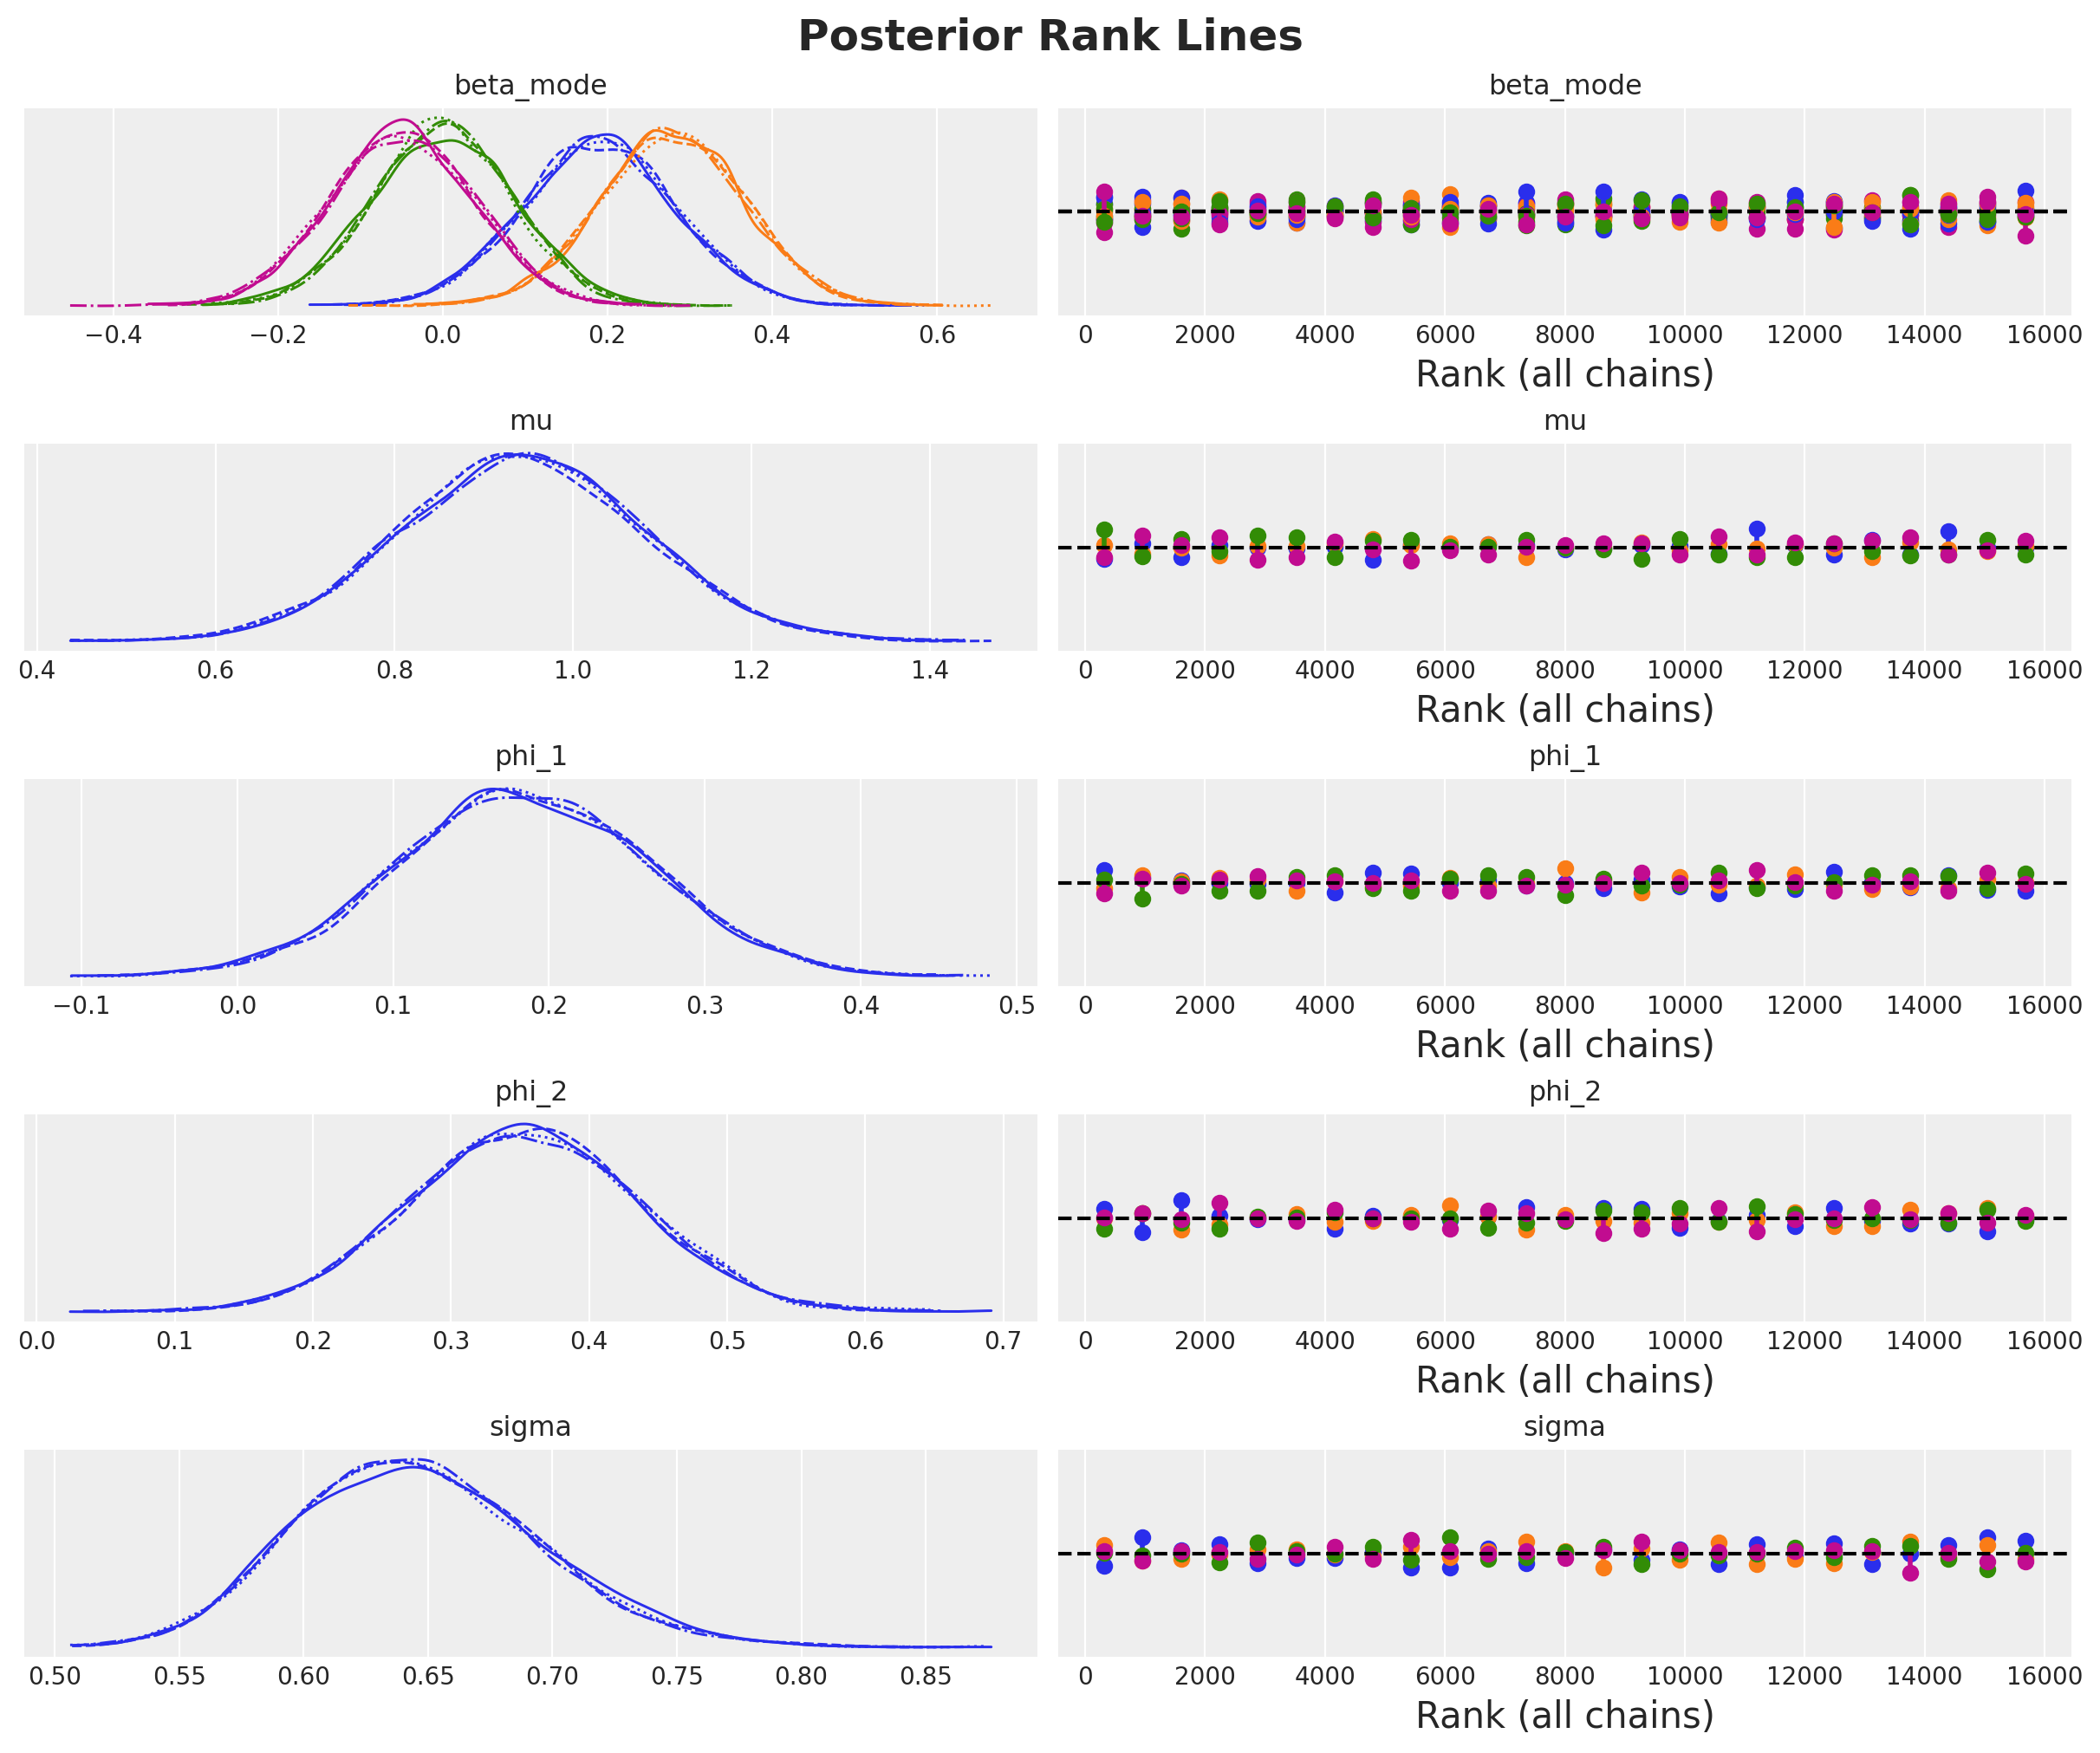

In [26]:
axes = az.plot_trace(
    data=idata,
    kind="rank_vlines",
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Posterior Rank Lines", fontsize=18, fontweight="bold");

In [27]:
predictive = Predictive(
    model=ar2_seasonal,
    posterior_samples=mcmc.get_samples(),
    return_sites=["pred", "y_forecast"],
)

rng_key, rng_subkey = random.split(rng_key)
forecast = predictive(
    rng_subkey,
    y=sales_obs_train,
    censored=jnp.concat([max_capacity_train, max_capacity_test_expected], axis=0),
    is_available=jnp.concatenate([is_available_train, is_available_test_expected]),
    fourier_features=jnp.concatenate([fourier_features_train, fourier_features_test]),
    future=forecast_horizon,
)

In [28]:
idata.extend(
    az.from_numpyro(
        posterior_predictive=forecast,
        coords={"t_test": t_test, "t": t[2:]},
        dims={"pred": ["t"], "y_forecast": ["t_test"]},
    )
)

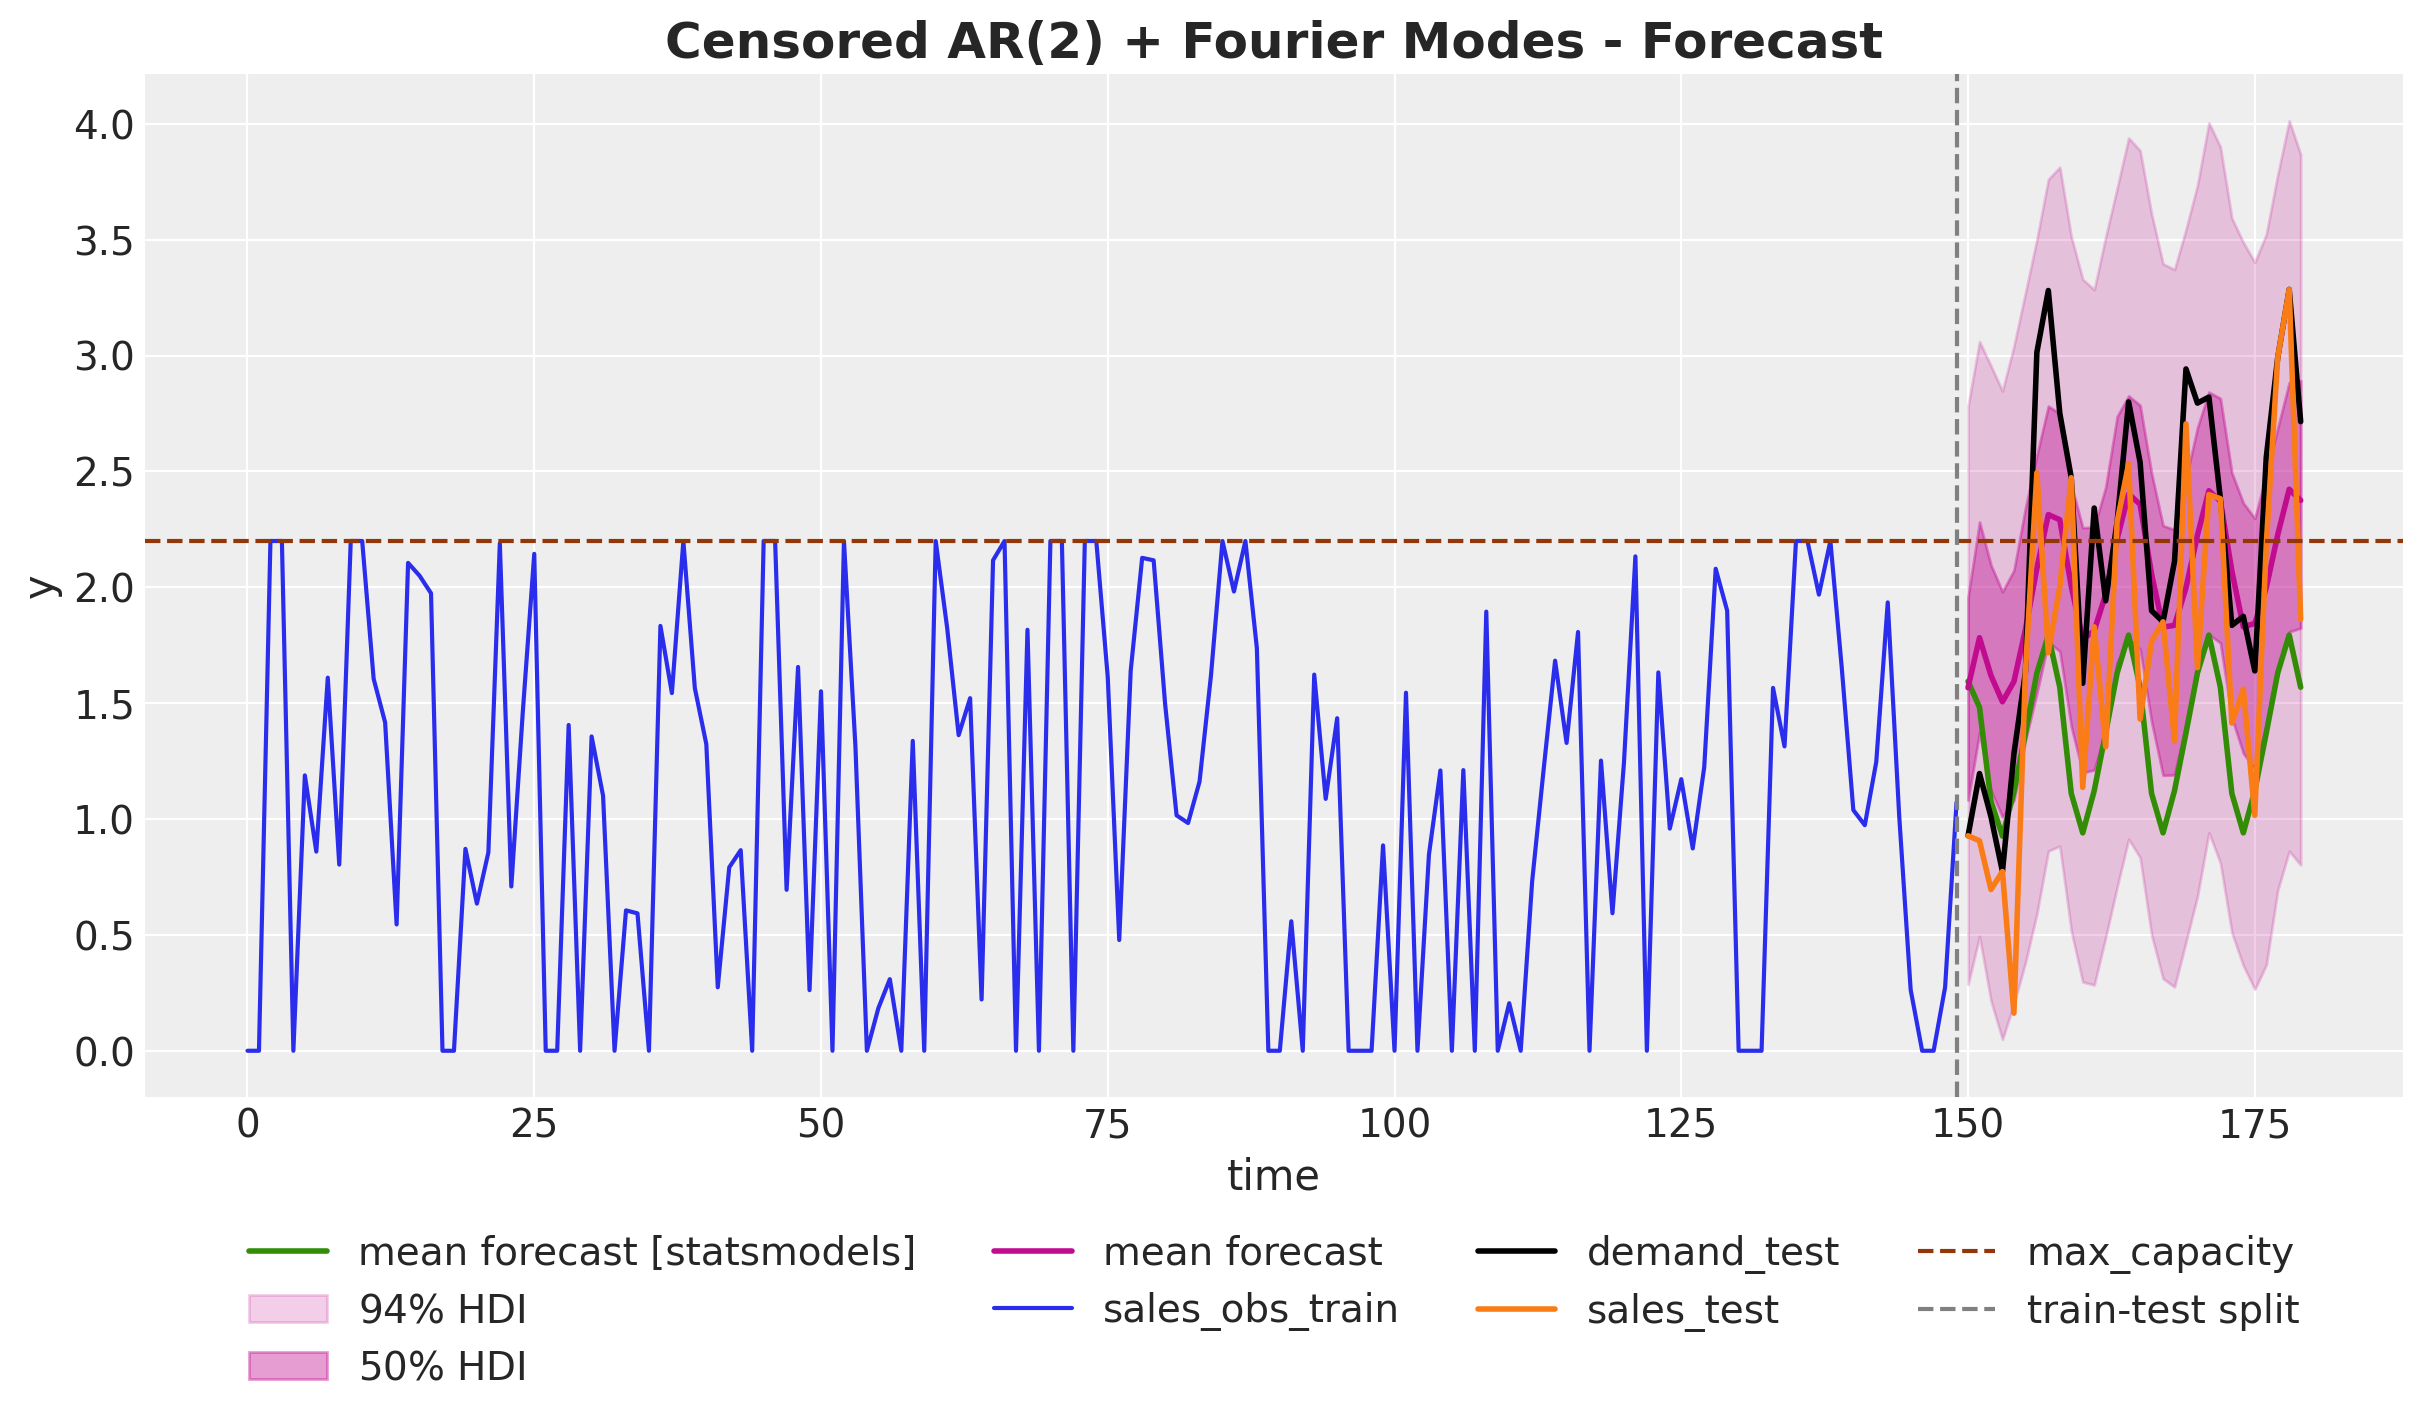

In [30]:
fig, ax = plt.subplots()
ax.plot(
    t_test,
    forecast_94_df["mean"],
    linewidth=2,
    color="C2",
    label="mean forecast [statsmodels]",
)
az.plot_hdi(
    t_test,
    idata.posterior_predictive["y_forecast"],
    smooth=False,
    hdi_prob=0.94,
    color="C3",
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HDI"},
)
az.plot_hdi(
    t_test,
    idata.posterior_predictive["y_forecast"],
    smooth=False,
    hdi_prob=0.50,
    color="C3",
    fill_kwargs={"alpha": 0.4, "label": r"$50\%$ HDI"},
)
ax.plot(
    t_test,
    idata.posterior_predictive["y_forecast"].mean(dim=("chain", "draw")),
    linewidth=2,
    color="C3",
    label="mean forecast",
)
ax.plot(t_train, sales_obs_train, color="C0", label="sales_obs_train")
ax.plot(t_test, demand_test, color="black", linewidth=2, label="demand_test")
ax.plot(t_test, sales_test, color="C1", linewidth=2, label="sales_test")
ax.axhline(y=data_params.max_caparity, c="C4", linestyle="--", label="max_capacity")
ax.axvline(x=t_train[-1], c="gray", linestyle="--", label="train-test split")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(xlabel="time", ylabel="y")
ax.set_title(
    "Censored AR(2) + Fourier Modes - Forecast", fontsize=18, fontweight="bold");